# Machine Learning: Assignment 3
**黄绵秋 19307130142**

## 任务描述
- 实现支持向量机`SVM`
- 通过`SVM`对`breast_cancer`数据集进行预测

## 数据描述
- `breast_cancer`数据集一共包含569组数据，按照恶性`malignant`和良性`benign`分为两类，分别被标注为0和1，每组数据包含30个特征
- 将特征数据和标签数据分别从`sklearn.datasets`中导出到变量`X,y`中
- `breast_cancer`数据集的一些信息如下

In [10]:
from sklearn import datasets
import numpy as np
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
print('data_size:', len(X))
print('feature_numbers:', len(X[0]))
print('target_names:',cancer.target_names)
print(cancer.DESCR)

data_size: 569
feature_numbers: 30
target_names: ['malignant' 'benign']
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each imag

## 数据描述
- 通过观察各个特征的数值大小，可以发现各个特征之间数量级差距较大，故而需要进行归一化处理

- 为对回归结果进行有效评估，将数据分割成训练集和测试集两部分，其中70%为训练集，30%为测试集。

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021, shuffle=True)
print('数据集size:\n', '训练集', X_train.shape, y_train.shape, '\n 测试集', X_test.shape, y_test.shape)

数据集size:
 训练集 (398, 30) (398,) 
 测试集 (171, 30) (171,)


## `SVM`模型
### `SVM`模型概述
支持向量机（`SVM`）是一种二分类模型，它的基本模型是定义在特征空间上的间隔最大的线性分类器，间隔最大使它有别于感知机；SVM还包括核技巧，这使它成为实质上的非线性分类器。SVM的的学习策略就是间隔最大化，可形式化为一个求解凸二次规划的问题，也等价于正则化的合页损失函数的最小化问题。SVM的的学习算法就是求解凸二次规划的最优化算法。

### 模型推导
#### 符号规定
$x_j^{(i)}$表示数据集第$i$个数据的第$j$个属性取值，$y^{(i)}$表示数据集第$i$个数据的标签值，$\hat{y}^{(i)}$表示第$i$组数据的计算预测值。数据集一共有$m$个数据，$n$种属性。

矩阵形式表示，$x_i=\begin{bmatrix}x_1^{(i)} & x_2^{(i)} & \cdots & x_n^{(i)}\end{bmatrix}$，$X=\begin{bmatrix}x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)} \\ x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)} \\ \cdots & \cdots & \cdots & \cdots \\ x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)}\end{bmatrix}$，参数$W=\begin{bmatrix}w_1 \\ w_2 \\ \vdots \\ w_n\end{bmatrix}$，数据集标签为$y=\begin{bmatrix}y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}\end{bmatrix}$

#### 模型目标
给定一个二分类器数据集 $\mathcal D=\{(x^(n), y^(n))\}_{n=1}^N$，其中$y^(n)\in\{-1,1\}$如果两类样本是线性可分的，即存在一个超平面$w^T+b=0$将两类样本分开，那么对于每个样本都有$y^{(n)}(w^Tx+b)>0$

数据集$\mathcal D$中每个样本$x^{(n)}$到分割超平面的距离为
$$\gamma^{(n)}=\frac{|w^Tx^{(n)}+b|}{||w||}=\frac{y^{(n)}(w^Tx+b)>0}{||w||}$$
我们定义**间隔**$\gamma$为整个数据集$\mathcal D$中所有样本到分割超平面的最短距离（$\gamma=\min\limits_n \gamma^{(n)}$.如果间隔$\gamma$越大，其分割超平面对两个数据集的划分越稳定，不容易受噪声等因素影响。**支持向量机的目标是寻找一个超平面 $(𝒘^*, 𝑏^* )$ 使得 𝛾 最大**，即
$$\max\limits_{w,b}\gamma\qquad s.t. \quad\frac{y^{(n)}(w^Tx^{(n)}+b)>0}{||w||}\geq\gamma, \quad\forall n\in\{1,2,\cdots,N\}$$
由于同时缩放$w\rightarrow kw$和$b\rightarrow kb$不会改变样本$x^{(n)}$到分割超平面的距离，我们可以限制$||w||\cdot y=1$，则公式上式等价于
$$\max\limits_{w,b}\frac{1}{||w||^2}\qquad s.t. \quad y^{(n)}(w^Tx^{(n)}+b)\geq 1, \quad\forall n\in\{1,2,\cdots,N\}$$

#### 理论推导
为了找到最大间隔分割超平面，将上一部分公式的目标函数写为凸优化问题
$$\max\limits_{w,b}\frac{1}{||w||^2}\qquad s.t. \quad 1-y^{(n)}(w^Tx^{(n)}+b)\leq 0, \quad\forall n\in\{1,2,\cdots,N\}$$
使用拉格朗日数乘法，其拉格朗日函数为
$$L(w,b,\alpha)=\frac{1}{2}||w||^2+\sum_{n=1}^N \alpha_n\left(1-y^{(n)}(w^Tx^{(n)}+b)\right)$$
其中$\alpha_i\geq 0$为拉格朗日乘数。计算$L(w,b,\alpha)$的导数，并令其等于0，得到
$$w=\sum_{n=1}^N\alpha_ny^{(n)}x^{(n)}\\0=\sum_{n=1}^N\alpha_ny^{(n)}$$
代入$L(w,b,\alpha)$，得到拉格朗日对偶函数
$$\Gamma(\alpha)=-\frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N\alpha_m\alpha_ny^{(m)}y^{(n)}\left(x^{(m)}\right)^Tx^{(n)}+\sum_{n=1}^N\alpha_n$$
支持向量机的主优化问题为凸优化问题，满足强对偶性，即主优化问题可以通过最大化对偶函数$\max\limits_{\alpha\geq 0}\Gamma(\alpha)$来求解。对偶函数$\Gamma(\alpha)$是一个凹函数，因此最大化对偶函数是一个凸优化问题，可以通过多种凸优化方法来进行求解，得到拉格朗日乘数的最优值$\alpha^*$．

根据[KKT条件](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions#Regularity_conditions_(or_constraint_qualifications))中的互补松弛条件，最优解满足$\alpha_n^*\left(1-y^{(n)}((w^*)^Tx^{(n)}+b^*)\right)=0$。如果样本$x^{(n)}$不在约束边界上，$\alpha_n^*=0$，其约束失效；如果样本$x^{(n)}$在约束边界上，$\alpha_n^*\geq 0$。这些在约束边界上的样本点称为**支持向量**，即离决策平面距离最近的点。但上述目标函数是存在假设数据完全线性可分的，但事实上我们的数据往往并不如此，所以我们会引入`松弛变量`，来允许部分数据点处于超平面的错误的一侧。这样我们的优化目标就能保持不变，但约束条件变为$0\leq\alpha_n\leq C$，其中参数$C>0$用来控制间隔和松弛变量惩罚的平衡。

#### 参数学习
首先利用凸优化算法计算出$\alpha^*$由于其约束条件的数量为训练样本数量，一般的优化方法代价比较高，因此在实践中通常采用比较高效的优化方法，比如序列最小优化（Sequential Minimal Optimization，SMO）算法。在算出$\alpha^*$之后由$w=\sum_{n=1}^N\alpha_ny^{(n)}x^{(n)}$计算出最优权重$w^*$，最优偏置$b^*$可以通过任选一个支持向量$(\tilde{x},\tilde{y})$计算得到$b^*=\tilde{y}-(w^*)^T\tilde{x}$，但实际的做法会是更具鲁棒性的$b^*=\frac{1}{N}\sum_{n=1}^{N}(y^{(n)}-(w^*)^Tx^{(n)})$

#### 核函数
以上讨论的都是在线性可分情况进行讨论的，但是实际问题中给出的数据并不是都是线性可分的，而非线性可分的数据没法直接分出决策平面。但对于低维平面内不可分的数据，放在一个高维空间中去就有可能变得可分。以二维平面的数据为例，我们可以通过找到一个映射将二维平面的点放到三维平面之中。理论上任意的数据样本都能够找到一个合适的映射使得这些在低维空间不能划分的样本到高维空间中之后能够线性可分。我们再来看一下之前的目标函数：
$$\Gamma(\alpha)=-\frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N\alpha_m\alpha_ny^{(m)}y^{(n)}\left(x^{(m)}\right)^Tx^{(n)}+\sum_{n=1}^N\alpha_n$$
而在引入核函数后，将特征向量映射到高维空间中，上述对偶问题变为如下形式：
$$\Gamma(\alpha)=-\frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N\alpha_m\alpha_ny^{(m)}y^{(n)}k(x^{(m)},x^{(n)})+\sum_{n=1}^N\alpha_n$$
其中$k(x^{(m)},x^{(n)})$为核函数

#### `SMO`算法
`SMO`算法的基本思路是先固定$\alpha_i$之外的所有参数，然后求$\alpha_i$上的极值，由于存在约束$\sum_{n=1}^N\alpha_ny^{(n)}=0$，若固定$\alpha_i$之外的其他变量，则$\alpha_i$可由其他变量导出。于是，`SMO`每次选择两个变量$\alpha_i$和$\alpha_j$，并固定其他参数。这样，在参数初始化后，`SMO`不断执行如下两个步骤
- 选取一对需要更新的变量$\alpha_i$和$\alpha_j$
- 固定$\alpha_i$和$\alpha_j$以外的参数，求解$\Gamma(\alpha)$获得更新后的$\alpha_i$和$\alpha_j$

首先将目标函数加上负号转换为求最小值问题
$$\min\limits_\alpha\frac{1}{2}\sum_{i=1}^N\sum_{i=1}^N\alpha^{(i)}\alpha^{(j)}y^{(i)}y^{(j)}(x^{(i)})^Tx^{(j)}\\s.t.\quad \sum_{i=1}^N\alpha_iy^{(i)}=0\\C\geq\alpha_i\geq 0,\ i=1,2,\cdots,N$$
假设我们取定了$\alpha_i,\alpha_j$，则有
$$\alpha_i^{new}y_i+\alpha_j^{new}y_j=\alpha_i^{old}y_i+\alpha_j^{old}y_j=\zeta$$
其中$\zeta$为常数。因为$\alpha_i$和$\alpha_j$不好同时求解，所以可以先求$\alpha_j$的解$\alpha_j^{new}$，再用$ \alpha_j^{new}$更新$\alpha_i^{new}$的解。为了求解$\alpha_j^{new}$需要先确定其取值范围，假设其上下边界分别为$H,L$，则有$L\leq \alpha_j^{new}\leq H$。而当$y^{(i)}$不等于$y^{(j)}$时(不妨设为$y^{(i)}=1, y^{(j)}=-1$)，则有$\alpha_i^{old}-\alpha_j^{old}=\zeta$，则
$$L=\max(0,-\zeta),\quad H=\min(C,C-\zeta)$$
当$y^{(i)}$等于$y^{(j)}$时，有
$$L=\max(0,\zeta-C),\quad H=\min(C,\zeta)$$
综述为
$$\left\{\begin{array}{rcl}& L=\max(0,-\zeta),\quad H=\min(C,C-\zeta),\quad &if\ y^{(i)}\neq y^{(j)}\\& L=\max(0,\zeta-C),\quad H=\min(C,\zeta),\quad &if\ y^{(i)}=y^{(j)}\end{array}\right.$$
令
$$f(x^{(t)})=\sum_{k=1, k\neq i,j}^N\alpha_ky^{(k)}(x^{(t)})^Tx^{(k)}+b\\v_t=\sum_{k=1, k\neq i,j}^N\alpha_ky^{(k)}(x^{(t)})^Tx^{(k)}=f(x^{(i)})-\alpha_iy^{(i)}(x^{(t)})^Tx^{(i)}-\alpha_jy^{(j)}(x^{(t)})^Tx^{(j)}-b$$
则最终目标函数记为
$$W(\alpha_j)=\alpha_i+\alpha_j-\frac{1}{2}\alpha_i^2(x^{(i)})^Tx^{(i)}-\frac{1}{2}\alpha_j^2(x^{(j)})^Tx^{(j)}-y^{(i)}y^{(j)}\alpha_i\alpha_j(x^{(i)})^Tx^{(j)}-y^{(i)}\alpha_iv_i-y^{(j)}\alpha_jv_j+constant$$

### 模型效果

In [12]:
from sklearn.svm import SVC
clf_rbf = SVC(kernel='rbf', C=100, gamma=0.1)
clf_rbf.fit(X_train, y_train)
score_rbf = clf_rbf.score(X_test, y_test)
print('rbf kernel:', score_rbf)

clf_linear = SVC(kernel='linear', C=100, gamma=0.1)
clf_linear.fit(X_train, y_train)
score_linear = clf_linear.score(X_test, y_test)
print('linear kernel:', score_linear)

# clf_poly = SVC(kernel='poly', C=100, gamma=0.1, degree=3)
# clf_poly.fit(X_train, y_train)
# score_poly = clf_poly.score(X_test, y_test)
# print('poly kernel:', score_poly)

clf_sigmoid = SVC(kernel='sigmoid', C=100, gamma=0.1)
clf_sigmoid.fit(X_train, y_train)
score_sigmoid = clf_sigmoid.score(X_test, y_test)
print('sigmoid kernel:', score_sigmoid)


rbf kernel: 0.6257309941520468
linear kernel: 0.9707602339181286
sigmoid kernel: 0.6257309941520468


### 模型调参
首先分析模型中各个参数的作用
- `C`表示错误项的惩罚系数。表示错误项的惩罚系数`C`越大，即对分错样本的惩罚程度越大，因此在训练样本中准确率越高，但是泛化能力降低；相反，减小`C`的话，容许训练样本中有一些误分类错误样本，泛化能力强。
- `kernel`表示核函数，可以是`linear`、`poly`、`rbf`、`sigmoid`、`precomputed`等。
- `degree`为`poly`多项式核函数的阶数
- `gamma`为核函数系数

#### 惩罚系数`C`
首先我们探讨惩罚系数的影响

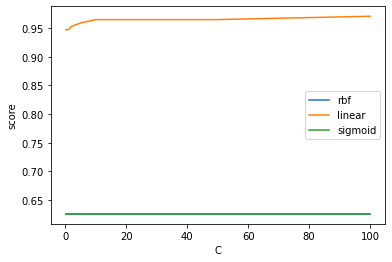

In [13]:
import matplotlib.pyplot as plt
CList = [0.1, 1, 2, 5, 10, 20, 50, 100]
scores_rbf = [] 
scores_linear = []
scores_poly = []
scores_sigmoid = []
for C in CList:
    clf_rbf = SVC(kernel='rbf', C=C, gamma=0.1)
    clf_rbf.fit(X_train, y_train)
    scores_rbf.append(clf_rbf.score(X_test, y_test))
    clf_linear = SVC(kernel='linear', C=C, gamma=0.1)
    clf_linear.fit(X_train, y_train)
    scores_linear.append(clf_linear.score(X_test, y_test))
    # clf_poly = SVC(kernel='poly', C=C, gamma=0.1, degree=3)
    # clf_poly.fit(X_train, y_train)
    # scores_poly.append(clf_poly.score(X_test, y_test))
    clf_sigmoid = SVC(kernel='sigmoid', C=C, gamma=0.1)
    clf_sigmoid.fit(X_train, y_train)
    scores_sigmoid.append(clf_sigmoid.score(X_test, y_test))
plt.xlabel('C')
plt.ylabel('score')
plt.plot(CList, scores_rbf, label='rbf')
plt.plot(CList, scores_linear, label='linear')
# plt.plot(CList, scores_poly, label='poly')
plt.plot(CList, scores_sigmoid, label='sigmoid')
plt.legend()
plt.show()


可以看出当`C`在2-10之间时效果较好。并且可以看出对于`breast_cancer`数据集而言，`linear`核函数的效果较好较稳定。

#### 核函数系数`gamma`
此处我们选取上一部分中表现最好的`linear`核函数和`C=10`

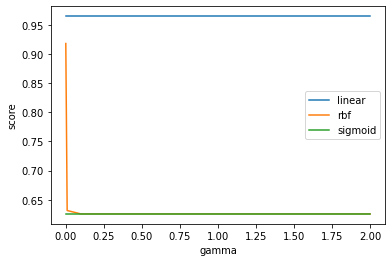

In [14]:
gammaList = [0.001, 0.01, 0.1, 1, 1.5, 2]
scores_linear = []
scores_rbf = []
scores_poly = []
scores_sigmoid = []
C = 10
for gamma in gammaList:
    clf_rbf = SVC(kernel='rbf', C=C, gamma=gamma)
    clf_rbf.fit(X_train, y_train)
    scores_rbf.append(clf_rbf.score(X_test, y_test))
    clf_linear = SVC(kernel='linear', C=C, gamma=gamma)
    clf_linear.fit(X_train, y_train)
    scores_linear.append(clf_linear.score(X_test, y_test))
    # clf_poly = SVC(kernel='poly', C=C, gamma=0.1, degree=3)
    # clf_poly.fit(X_train, y_train)
    # scores_poly.append(clf_poly.score(X_test, y_test))
    clf_sigmoid = SVC(kernel='sigmoid', C=C, gamma=gamma)
    clf_sigmoid.fit(X_train, y_train)
    scores_sigmoid.append(clf_sigmoid.score(X_test, y_test))
plt.xlabel('gamma')
plt.ylabel('score')
plt.plot(gammaList, scores_linear, label='linear')
plt.plot(gammaList, scores_rbf, label='rbf')
# plt.plot(gammaList, scores_poly, label='poly')
plt.plot(gammaList, scores_sigmoid, label='sigmoid')
plt.legend()
plt.show()

看出`gamma`在较大时几乎无影响，在很小时对`rbf`核函数有一定影响，且增大会使得`rbf`核函数准确性下降

## 模型优化
- 在上述实验中发现`sigmoid`和`rbf`核函数表现均不好，`poly`甚至会发生运行时间过长的情况，所以我们需要思考为什么会出现这种情况。
$$K_{linear}(x,z)=x\cdot z\\ K_{poly}(x,z)=(\gamma x\cdot z+r)^d\\K_{rbf}(x,z)=e^{-\gamma||x-z||^2}\\K_{sigmoid}(x,z)=tanh(\gamma x\cdot z+r)$$
  可以看出`sigmoid`和`rbf`中不同量级的数值会对核函数结果影响不同，而`linear`则只是单纯的$x\cdot z$只跟同一量级的数值有关，所以效果不错。为了消除这种影响，我们可以对数据进行标准化处理，使得不同维度的数据都有相同的量级。

In [15]:
print(X[0])
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X=X)
print(X[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021, shuffle=True)


[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
[0.52103744 0.0226581  0.54598853 0.36373277 0.59375282 0.7920373
 0.70313964 0.73111332 0.68636364 0.60551811 0.35614702 0.12046941
 0.3690336  0.27381126 0.15929565 0.35139844 0.13568182 0.30062512
 0.31164518 0.18304244 0.62077552 0.14152452 0.66831017 0.45069799
 0.60113584 0.61929156 0.56861022 0.91202749 0.59846245 0.41886396]


In [16]:
clf_rbf = SVC(kernel='rbf', C=100, gamma=0.1)
clf_rbf.fit(X_train, y_train)
score_rbf = clf_rbf.score(X_test, y_test)
print('rbf kernel:', score_rbf)

clf_linear = SVC(kernel='linear', C=100, gamma=0.1)
clf_linear.fit(X_train, y_train)
score_linear = clf_linear.score(X_test, y_test)
print('linear kernel:', score_linear)

clf_poly = SVC(kernel='poly', C=100, gamma=0.1, degree=3)
clf_poly.fit(X_train, y_train)
score_poly = clf_poly.score(X_test, y_test)
print('poly kernel:', score_poly)

clf_sigmoid = SVC(kernel='sigmoid', C=100, gamma=0.1)
clf_sigmoid.fit(X_train, y_train)
score_sigmoid = clf_sigmoid.score(X_test, y_test)
print('sigmoid kernel:', score_sigmoid)

rbf kernel: 0.9649122807017544
linear kernel: 0.9532163742690059
poly kernel: 0.9707602339181286
sigmoid kernel: 0.9707602339181286


可以看出，在进行归一化处理后，各个核函数效果均较好，消除了数据的不稳定性。

- 使用划分数据集的方式进行训练，会有较强的数据相关性。所以可以采用`KFold`交叉验证的方式进行训练。

In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2021)
scores_linear = []
scores_sigmoid = []
scores_rbf = []
scores_poly = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf_rbf = SVC(kernel='rbf', C=100, gamma=0.1)
    clf_rbf.fit(X_train, y_train)
    scores_rbf.append(clf_rbf.score(X_test, y_test))
    clf_linear = SVC(kernel='linear', C=100, gamma=0.1)
    clf_linear.fit(X_train, y_train)
    scores_linear.append(clf_linear.score(X_test, y_test))
    clf_poly = SVC(kernel='poly', C=100, gamma=0.1, degree=3)
    clf_poly.fit(X_train, y_train)
    scores_poly.append(clf_poly.score(X_test, y_test))
    clf_sigmoid = SVC(kernel='sigmoid', C=100, gamma=0.1)
    clf_sigmoid.fit(X_train, y_train)
    scores_sigmoid.append(clf_sigmoid.score(X_test, y_test))
print('rbf kernel:', np.mean(score_rbf))
print('linear kernel:', np.mean(scores_linear))
print('poly kernel:', np.mean(scores_poly))
print('sigmoid kernel:', np.mean(scores_sigmoid))

rbf kernel: 0.9649122807017544
linear kernel: 0.9648657040832169
poly kernel: 0.9771619313771154
sigmoid kernel: 0.9683744760130415


## 总结
本次实验，通过调用`sklearn`的`svm`模型，对`breast_cancer`数据集进行了训练和预测，并对模型的效果进行了评估。过程中探讨了不同参数的影响，并对模型的调参进行了探讨。经过调参看出`svm`中核函数的选取和`C`的选取对模型的效果有着重要的影响，且由于`SVM`是对超平面的选取，所以不同维度数量级不同的数据而言，超平面的选取时会有较大程度的激荡，所以进行`SVM`训练前必须需要进行归一化处理消除不同维度数据的不同影响。